In [1]:
#Import Block
from selenium import webdriver #Webtesting library, used to automate browser activities
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.wait import WebDriverWait
import selenium.webdriver.support.expected_conditions as conditions
from bs4 import BeautifulSoup #used to parse html and xml documents
import pandas as pd

<h1><u> Mission Statement</u> </h1>
<br>
Web Scraping is used to collect usually large amounts of information from websites.<br>
It's only allowed based on a website's "robots.txt" file that secifies what resources can be gathered from the site. <br>
My goal is to scrape information on the best-selling Fantasy books from Barnes and Noble as its a major retailer of them and find the best-preforming Author as of May 3rd, 2023. <br>
I will collect:
<li> Names of the books
<li> Hardcover Price of the books
<li> Ebook Price of the books
<li> Author(s) of the books
<li> Publication Date of the books
<li> Sales Rank of the books
<li> Rating of the books


<h2><u> Scraping

In [64]:
#Opening the driver code
driver = webdriver.Edge()
driver.get("https://www.barnesandnoble.com/b/books/science-fiction-fantasy/fantasy-fiction/_/N-29Z8q8Z182u")
driver.implicitly_wait(4)
#Will click accept cookies so it dosen't interrupt the loop
acceptcookies = driver.find_element(by = 'id', value = "onetrust-accept-btn-handler")
acceptcookies.click()

In [66]:
#Main extraction code
    #Setting up empty lists
Names = []
Ratings = []
HPrice = []
EPrice = []
Authors = []
PubDate = []
SalesRank = []

page = 1
booksclicked = 0
while page <= 5:    
    
    if page == 2:
        pagetwo = driver.find_element(by = "xpath", value = '//a[@href="https://www.barnesandnoble.com/b/books/science-fiction-fantasy/fantasy-fiction/_/N-29Z8q8Z182u?Nrpp=20&page=2"]')
        pagetwo.click()
        booksclicked = 0
    
    elif page == 3:
        pagethree = driver.find_element(by = "xpath", value = '//a[@href="https://www.barnesandnoble.com/b/books/science-fiction-fantasy/fantasy-fiction/_/N-29Z8q8Z182u?Nrpp=20&page=3"]')
        pagethree.click()
        booksclicked = 0
                                        
    elif page == 4:
        pagefour = driver.find_element(by = "xpath", value = '//a[@href="https://www.barnesandnoble.com/b/books/science-fiction-fantasy/fantasy-fiction/_/N-29Z8q8Z182u?Nrpp=20&page=4"]')
        pagefour.click()
        booksclicked = 0
    elif page == 5:
        pagefive = driver.find_element(by = "xpath", value = '//a[@href="https://www.barnesandnoble.com/b/books/science-fiction-fantasy/fantasy-fiction/_/N-29Z8q8Z182u?Nrpp=20&page=5"]')
        pagefive.click()
        booksclicked = 0
    while booksclicked < 20:
        for x in range(0,20):
            
            #Clicks the book and waits for browser to load before extracting information
            booksonpage = driver.find_elements(by = 'class name', value= "pImageLink ")
            link = booksonpage[booksclicked] #Need to do this so the element is not stale
            WebDriverWait(driver, timeout=10).until(conditions.element_to_be_clickable(link))
            action_chain = ActionChains(driver)                                         
            action_chain.scroll_to_element(link).perform()
            link.click()

            #Passes the page to soup module
            html = driver.page_source
            soup = BeautifulSoup(html, "html5lib")

            #Grabs all the information neccessary
            try:
                bookauthor = soup.find(name = "div", attrs = {"id" : "pdp-header-authors"}).find(name = "a").get_text()
                booktitle = soup.find(name = "div", attrs = {"id" : "pdp-header-info"}).find(name = "h1").get_text()
                bookrating = soup.find(name = "div", attrs = {"class": "bv_avgRating_component_container notranslate"}).get_text()
                bookhprice = soup.find(name = "span",attrs = {"class" : "price current-price ml-0"}).get_text() #hardcover price
                bookeprice = soup.find_next(name = "span",attrs = { "class" : "format-price"}).find_next(name = "span",\
                attrs ={"class" : "format-price"}).next_element.next_element.get_text() #ebook price
                booktable = soup.find(name = "table", attrs = {"class" : "plain centered" })
                bookpubdate = booktable.find(name = "th",string = "Publication date:").previous_element.previous_element.find(name = "td").get_text()
                booksalesrank = booktable.find(name = "th", string = "Sales rank:").next_element.next_element.next_element.get_text()
            except AttributeError:
                if bookeprice is None:
                    bookeprice = "N/A"
                elif bookhprice is None:
                    bookhprice = "N/A"

            #Appends all the info into empty lists
            Names.append(booktitle)
            Ratings.append(bookrating)
            HPrice.append(bookhprice)
            EPrice.append(bookeprice)
            Authors.append(bookauthor)
            PubDate.append(bookpubdate)
            SalesRank.append(booksalesrank)

        #At the initial end of the loop, add to booksclicked variable and go back to the main page    
            booksclicked += 1
            driver.back()
    #At the end of the while loop, add to the page count to trigger the if/elif statements
    page += 1
                                        
driver.quit()   

In [149]:
Fantasy = pd.DataFrame([])
Fantasy["Names"] = Names
Fantasy["Author(s)"] = Authors
Fantasy["Ratings"] = Ratings
Fantasy["Hard Cover Price"] = HPrice
Fantasy["E-Book Price"] = EPrice
Fantasy["Publication Date"] = PubDate
Fantasy["Sales Ranking"] = SalesRank
Fantasy["Sales Ranking"] = Fantasy["Sales Ranking"].str.replace(",","").astype(dtype = int)
Fantasy['Publication Date'] =  pd.to_datetime(PubDate)
Fantasy.sort_values("Sales Ranking",inplace = True)
Fantasy.set_index(keys = (["Author(s)", "Names"]), inplace = True)
Fantasy

Ratings  \
Author(s)      Names                                                        
Rebecca Yarros Fourth Wing                                            5.0   
Sarah J. Maas  A Court of Mist and Fury (A Court of Thorns and...     5.0   
               A Court of Thorns and Roses (A Court of Thorns ...     4.7   
               A Court of Wings and Ruin (A Court of Thorns an...     4.9   
               A Court of Frost and Starlight (A Court of Thor...     4.0   
...                                                                   ...   
Ilona Andrews  Magic Tides                                            4.8   
V. E. Schwab   The Fragile Threads of Power (B&N Exclusive Edi...     4.0   
Jim Butcher    Instinct: An Animal Rescuers Anthology                 4.0   
Brent Weeks    The Way of Shadows (Night Angel Trilogy #1)            4.6   
C. J. Archer   The Mapmaker's Apprentice (Glass and Steele Ser...     4.7   

                                                                  Hard Cover Price  \
Author(s)      Names                                                                 
Rebecca Yarros Fourth Wing                                                  $26.99   
Sarah J. Maas  A Court of Mist and Fury (A Court of Thorns and...           $26.99   
               A Court of Thorns and Roses (A Court of Thorns ...           $15.99   
               A Court of Wings and Ruin (A Court of Thorns an...           $16.99   
               A Court of Frost and Starlight (A Court of Thor...           $14.99   
...                                                                            ...   
Ilona Andrews  Magic Tides                                                   $9.99   
V. E. Schwab   The Fragile Threads of Power (B&N Exclusive Edi...           $19.99   
Jim Butcher    Instinct: An Animal Rescuers Anthology                       $19.99   
Brent Weeks    The Way of Shadows (Night Angel Trilogy #1)                  $18.99   
C. J. Archer   The Mapmaker's Apprentice (Glass and Steele Ser...           $10.99   

                                                                  E-Book Price  \
Author(s)      Names                                                             
Rebecca Yarros Fourth Wing                                              $14.99   
Sarah J. Maas  A Court of Mist and Fury (A Court of Thorns and...       $14.99   
               A Court of Thorns and Roses (A Court of Thorns ...       $15.99   
               A Court of Wings and Ruin (A Court of Thorns an...       $16.99   
               A Court of Frost and Starlight (A Court of Thor...       $14.99   
...                                                                        ...   
Ilona Andrews  Magic Tides                                               $4.99   
V. E. Schwab   The Fragile Threads of Power (B&N Exclusive Edi...        $6.99   
Jim Butcher    Instinct: An Animal Rescuers Anthology                    $6.99   
Brent Weeks    The Way of Shadows (Night Angel Trilogy #1)               $6.99   
C. J. Archer   The Mapmaker's Apprentice (Glass and Steele Ser...        $4.99   

                                                                  Publication Date  \
Author(s)      Names                                                                 
Rebecca Yarros Fourth Wing                                              2023-05-02   
Sarah J. Maas  A Court of Mist and Fury (A Court of Thorns and...       2023-05-02   
               A Court of Thorns and Roses (A Court of Thorns ...       2020-06-02   
               A Court of Wings and Ruin (A Court of Thorns an...       2020-06-02   
               A Court of Frost and Starlight (A Court of Thor...       2020-06-02   
...                                                                            ...   
Ilona Andrews  Magic Tides                                              2023-01-17   
V. E. Schwab   The Fragile Threads of Power (B&N Exclusive Edi...       2023-03-22   
Jim Butcher    Ins

<h2><u>Takeaways

<AxesSubplot:>

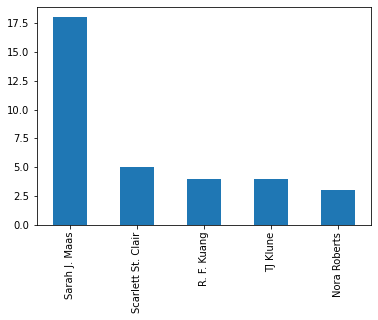

In [162]:
Fantasycopy = Fantasy.reset_index().copy()
Fantasycopy["Author(s)"].value_counts().head(5).plot(kind = "bar")

<b>The 5 most repeated authors in the first 100 bestselling fantasy book on Barnes and Nobles are Sarah J. Maas, Scarlett St. Clair, R. F. Kuang, TJ Klune and Nora Roberts as of May 3rd, 2023!

In [119]:
mask = Fantasy["Publication Date"] >= "2023-01-01"
Fantasy[mask].head(5)

Ratings  \
Author(s)         Names                                                        
Rebecca Yarros    Fourth Wing                                            5.0   
Sarah J. Maas     A Court of Mist and Fury (A Court of Thorns and...     5.0   
                  Throne of Glass (Throne of Glass Series #1)            4.6   
                  Crown of Midnight (Throne of Glass Series #2)          4.7   
Carissa Broadbent The Serpent and the Wings of Night                     4.8   

                                                                     Hard Cover Price  \
Author(s)         Names                                                                 
Rebecca Yarros    Fourth Wing                                                  $26.99   
Sarah J. Maas     A Court of Mist and Fury (A Court of Thorns and...           $26.99   
                  Throne of Glass (Throne of Glass Series #1)                  $19.00   
                  Crown of Midnight (Throne of Glass Series #2)                $19.00   
Carissa Broadbent The Serpent and the Wings of Night                           $24.99   

                                                                     E-Book Price  \
Author(s)         Names                                                             
Rebecca Yarros    Fourth Wing                                              $14.99   
Sarah J. Maas     A Court of Mist and Fury (A Court of Thorns and...       $14.99   
                  Throne of Glass (Throne of Glass Series #1)              $19.00   
                  Crown of Midnight (Throne of Glass Series #2)            $19.00   
Carissa Broadbent The Serpent and the Wings of Night                       $19.00   

                                                                     Publication Date  \
Author(s)         Names                                                                 
Rebecca Yarros    Fourth Wing                                              2023-05-02   
Sarah J. Maas     A Court of Mist and Fury (A Court of Thorns and...       2023-05-02   
                  Throne of Glass (Throne of Glass Series #1)              2023-02-14   
                  Crown of Midnight (Throne of Glass Series #2)            2023-02-14   
Carissa Broadbent The Serpent and the Wings of Night                       2023-02-14   

                                                                      Sales Ranking  
Author(s)         Names                                                              
Rebecca Yarros    Fourth Wing                                                     4  
Sarah J. Maas     A Court of Mist and Fury (A Court of Thorns and...              4  
                  Throne of Glass (Throne of Glass Series #1)                    47  
                  Crown of Midnight (Throne of Glass Series #2)                  55  
Carissa Broadbent The Serpent and the Wings of Night                             55

<b>The top 5 performing fantasy books from 2023 are Fourth Wing, A Court of Mist and Fury, Throne of Glass, Crown of Midnight and The Serpent and the Wings of Night as of May 3rd 2023.

In [124]:
mask1 = Fantasy["Publication Date"] > "2021-12-31"
mask2 = Fantasy["Publication Date"] < "2023-01-01"
Fantasy[mask1 & mask2].head(5)

,,Ratings,Hard Cover Price,E-Book Price,Publication Date,Sales Ranking
Author(s),Names,,,,,
Sarah J. Maas,A Court of Silver Flames (B&N Exclusive Edition) (A Court of Thorns and Roses Series #4),4.5,$19.00,$19.99,2022-09-06,46
Stephen King,Fairy Tale,4.6,$22.75,$18.00,2022-09-06,361
C. J. Archer,The Librarian of Crooked Lane,5.0,$3.99,$9.99,2022-09-06,428
Ellen Datlow (Editor),Lovecraft Unbound,5.0,$1.99,$14.99,2022-11-08,598
Travis Baldree,Legends & Lattes: A Novel of High Fantasy and Low Stakes,4.8,$14.99,$14.99,2022-11-08,598


<b>The top 5 performing fantasy books from 2022 are A Court of Silver Flames, Fairy Tale, The Librarian of Crooked Lane, Lovecraft Unbound and Legends & Lattes.

In [116]:
Fantasy.sort_values("Ratings").head(2)

,,Ratings,Hard Cover Price,E-Book Price,Publication Date,Sales Ranking
Author(s),Names,,,,,
Leigh Bardugo,Hell Bent (B&N Exclusive Edition),3.4,$26.99,$24.99,2023-01-10,870
Andy Redsmith,Breaking the Lore,3.5,$8.49,$26.99,2023-01-31,351


<b> The lowest rated books (lower than a rating of 4) of the 100 best-selling books on Barnes and Noble are Hell Bent by Leigh Bardugo and Breaking the Lore by Andy Redsmith as of May 3rd, 2023.

In [117]:
Fantasy.head(5)

Ratings  \
Author(s)      Names                                                        
Rebecca Yarros Fourth Wing                                            5.0   
Sarah J. Maas  A Court of Mist and Fury (A Court of Thorns and...     5.0   
               A Court of Thorns and Roses (A Court of Thorns ...     4.7   
               A Court of Wings and Ruin (A Court of Thorns an...     4.9   
               A Court of Frost and Starlight (A Court of Thor...     4.0   

                                                                  Hard Cover Price  \
Author(s)      Names                                                                 
Rebecca Yarros Fourth Wing                                                  $26.99   
Sarah J. Maas  A Court of Mist and Fury (A Court of Thorns and...           $26.99   
               A Court of Thorns and Roses (A Court of Thorns ...           $15.99   
               A Court of Wings and Ruin (A Court of Thorns an...           $16.99   
               A Court of Frost and Starlight (A Court of Thor...           $14.99   

                                                                  E-Book Price  \
Author(s)      Names                                                             
Rebecca Yarros Fourth Wing                                              $14.99   
Sarah J. Maas  A Court of Mist and Fury (A Court of Thorns and...       $14.99   
               A Court of Thorns and Roses (A Court of Thorns ...       $15.99   
               A Court of Wings and Ruin (A Court of Thorns an...       $16.99   
               A Court of Frost and Starlight (A Court of Thor...       $14.99   

                                                                  Publication Date  \
Author(s)      Names                                                                 
Rebecca Yarros Fourth Wing                                              2023-05-02   
Sarah J. Maas  A Court of Mist and Fury (A Court of Thorns and...       2023-05-02   
               A Court of Thorns and Roses (A Court of Thorns ...       2020-06-02   
               A Court of Wings and Ruin (A Court of Thorns an...       2020-06-02   
               A Court of Frost and Starlight (A Court of Thor...       2020-06-02   

                                                                   Sales Ranking  
Author(s)      Names                                                              
Rebecca Yarros Fourth Wing                                                     4  
Sarah J. Maas  A Court of Mist and Fury (A Court of Thorns and...              4  
               A Court of Thorns and Roses (A Court of Thorns ...             22  
               A Court of Wings and Ruin (A Court of Thorns an...             25  
               A Court of Frost and Starlight (A Court of Thor...             40

<b> The 5 best performing best-selling fantasy books of the 100 best-selling books are Fourth Wing, A Court of Mist and Fury, A Court of Thorns and Roses, A Court of Wings and Ruin and A Court of Frost and Starlight as of May 3rd, 2023.

<b>This makes Sarah J. Maas and her "A Court of Thorn and Roses" series the top-charting fantasy book series and author on Barnes and Noble as of May 3rd, 2023!